# Анализ бизнес-показателей.

**Описание проекта**

В нашем распоряжении данные для анализа развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Наша задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
- лог сервера с данными об их посещениях,
- выгрузка их покупок за этот период,
- рекламные расходы.

Нам предстоит изучить:
- откуда приходят пользователи и какими устройствами они пользуются,
- сколько стоит привлечение пользователей из различных рекламных каналов;
- сколько денег приносит каждый клиент,
- когда расходы на привлечение клиента окупаются,
- какие факторы мешают привлечению клиентов

### Загрузим данные и подготовим их к анализу.

**Описание данных**

В вашем распоряжении три датасета.

Файл *visits_info_short.csv* хранит лог сервера с информацией о посещениях сайта, 
*orders_info_short.csv* — информацию о заказах, 
а *costs_info_short.csv* — информацию о расходах на рекламу.

Структура **visits_info_short.csv**:
- User Id — уникальный идентификатор пользователя,
- Region — страна пользователя,
- Device — тип устройства пользователя,
- Channel — идентификатор источника перехода,
- Session Start — дата и время начала сессии,
- Session End — дата и время окончания сессии.

Структура **orders_info_short.csv**:
- User Id — уникальный идентификатор пользователя,
- Event Dt — дата и время покупки,
- Revenue — сумма заказа.

Структура **costs_info_short.csv**:
- dt — дата проведения рекламной кампании,
- Channel — идентификатор рекламного источника,
- costs — расходы на эту кампанию.

Изучим данные и выполним предобработку.

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns

#загрузим данные о визитах, заказах и рекламных расходах из CSV-файлов в переменные
visits, orders, costs = (
    pd.read_csv('/datasets/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('/datasets/orders_info_short.csv'),  # заказы
    pd.read_csv('/datasets/costs_info_short.csv'),  # расходы
)

In [2]:
#посмотрим на данные в таблицах
for i in [visits, orders, costs]:
    display(i.head())
    display(i.info())

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


None

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


None

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


None

Мы видим несколько недочетов в данных, а именно: некорректный тип даты и времени и названия столбцов не соответсвуют правильному написанию кода. Исправим это.

In [3]:
#переименуем столбцы: приведем к змеиному регистру, заменим пробелы
visits.columns = visits.columns.str.lower().str.replace(' ','_')
orders.columns = orders.columns.str.lower().str.replace(' ','_')
costs.columns = costs.columns.str.lower()
#посмотрим, все ли корректно
for i in [visits, orders, costs]:
    display(i.head())

,user_id,region,device,channel,session_start,session_end
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


,user_id,event_dt,revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


,dt,channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [4]:
# преобразуем данные о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Также проверим, присутствуют ли пропущенные значения и явные дубликаты в наших данных.

In [5]:
#проверим пропуски
df_list = [visits, orders, costs]
for i in df_list:
    print(i.isna().sum())
    print()

user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64

user_id     0
event_dt    0
revenue     0
dtype: int64

dt         0
channel    0
costs      0
dtype: int64



In [6]:
#посмотрим, есть ли дубликаты
for i in df_list:
    print(i.duplicated().sum())

0
0
0


Мы сохранили наши таблицы с данными в переменные и изучили их, после чего провели преодобработку:
- изменили тип данных о дате и времени на корректный;
- привели названия столбцов к змеиному регистру, убрали пробелы;
- убедились, что явные дубликаты и пропущенные значения отсутствуют.

Можем переходить к следующему этапу исследования.

### Зададим функции для расчёта и анализа LTV, ROI, удержания и конверсии.

Функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

Функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

In [7]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [8]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [9]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [10]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [11]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [12]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [13]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [14]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

### Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определим каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

#### Профили пользователей.

In [15]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, events = None, ad_costs = costs)
profiles.head(5) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [16]:
#определяем миимальную и максимальную дату привлечения пользователей
min_analysis_date = profiles['dt'].min() #сохраняем минимальную дату
max_analysis_date = profiles['dt'].max() #сохраняем максимальную дату
display(min_analysis_date)
display(max_analysis_date)

datetime.date(2019, 5, 1)

datetime.date(2019, 10, 27)

С помощью функции *get_profiles ( )* мы получили профили пользователей нашего приложения. Убедились, что в нашем распоряжении данные с 1 мая 2019 по 27 октября 2019 года.

#### Распределение пользователей по странам.

In [17]:
#сгруппируем данные по региону и выведем количесво уникальных пользователей по каждому из них
profiles.groupby('region').agg({'user_id': 'nunique'})

,user_id
region,
France,17450
Germany,14981
UK,17575
United States,100002


In [18]:
#построим таблицу, отражающую количество пользователей и долю платящих из каждой страны
import warnings
warnings.filterwarnings("ignore")

payer_of_region = (
    profiles.groupby('region')['user_id', 'payer']
    .agg({'user_id': 'nunique', 'payer':'sum'})
).reset_index()
payer_of_region['payers_per'] = payer_of_region['payer'] / payer_of_region['user_id'] *100
payer_of_region.sort_values(by='payers_per', ascending=False).style.format({'payers_per': '{:.2f}%'})

,region,user_id,payer,payers_per
3,United States,100002,6902,6.90%
1,Germany,14981,616,4.11%
2,UK,17575,700,3.98%
0,France,17450,663,3.80%


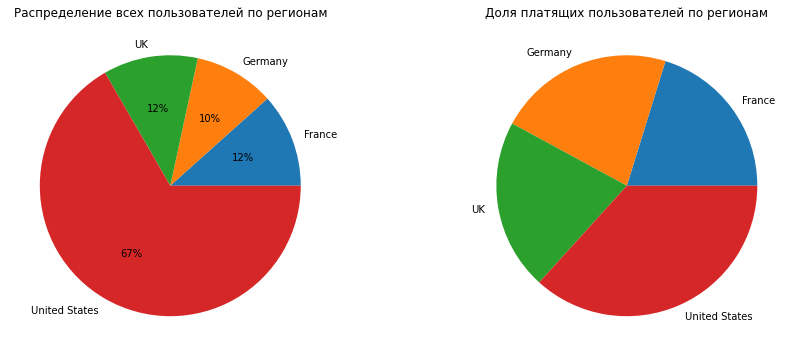

In [19]:
#построим графики для наглядности
fig, ax = plt.subplots(1, 2, figsize = (15, 6),  squeeze=False)
ax[0][0].pie(payer_of_region.user_id, labels=payer_of_region.region, autopct='%1.0f%%')
ax[0][0].set(title='Распределение всех пользователей по регионам')
ax[0][1].pie(payer_of_region.payers_per, labels=payer_of_region.region)
ax[0][1].set(title='Доля платящих пользователей по регионам')
plt.show()

Мы выяснили, что приложением пользуются в 4 странах: United States, UK, France и Germany. Наибольшее число пользователей из Америки, они составляют 67% (100 тыс. пользователей) от общего числа, доля Франции и Великобритании примерно одинаковая - по 12%, пользователей из Германии меньше всего - около 10%.
Так как подавляющее количество пользователей нашего приложения из США, логично, что и количество платящих пользователей больше именно из этой страны, а именно - 6902 человека (этот показатель практически в 10 раз выше, чем количество платящих пользователей из других стран). 
Что касается процентного соотношения, тут мы видим, что доля платящих пользователей из США также самая высокая - 6.9%, Германия, Великобритания и Франция отстают, доля платящих по этим странам составляет 4.11%, 3.98% и 3.8% соответственно.

#### Распределение пользователей по устройствам.

In [20]:
#построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
payer_of_device = (
    profiles.groupby('device')['user_id', 'payer']
    .agg({'user_id': 'nunique', 'payer':'sum'})
).reset_index()
payer_of_device['payers_per'] = payer_of_device['payer'] / payer_of_device['user_id'] *100
payer_of_device.sort_values(by='payers_per', ascending=False).style.format({'payers_per': '{:.2f}%'})

,device,user_id,payer,payers_per
1,Mac,30042,1912,6.36%
3,iPhone,54479,3382,6.21%
0,Android,35032,2050,5.85%
2,PC,30455,1537,5.05%


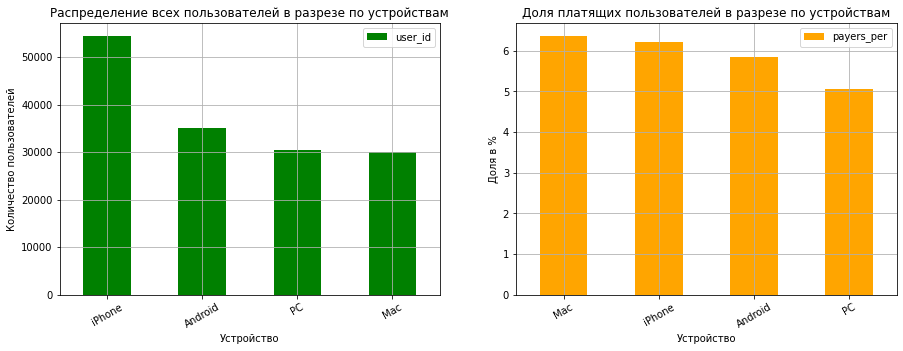

In [21]:
#построим графики для наглядности
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
payer_of_device.sort_values(by='user_id', ascending=False).plot.bar(
                                                           x='device', y='user_id', grid=True,
                                                           title='Распределение всех пользователей в разрезе по устройствам', 
                                                           rot=30, color= 'green', ax=ax1).set(xlabel='Устройство', 
                                                                               ylabel='Количество пользователей')

ax2 = plt.subplot(1, 2, 2)
payer_of_device.sort_values(by='payers_per', ascending=False).plot.bar(
                                                             x='device', y='payers_per', grid=True,
                                                             title='Доля платящих пользователей в разрезе по устройствам',
                                                             rot=30,color='orange', ax=ax2).set(xlabel='Устройство', 
                                                                                           ylabel='Доля в %')

plt.show()

Самым популярным устройством, с которого пользователи заходят в приложение, является - iPhone, он лидирует с большим отрывом от остальных (54.5 тыс пользователей), на втором месте устройства на платформе Android (35 тыс.), пользователей на PC и Mac меньшего всего - по 30 тыс.
Наибольшее количество платящих пользователей также с устройства iPhone (3382 человека), но если смотреть на долю платящих пользователей, то видим практически равномерное распределние между Mac, iPhone и Android (6.36%, 6.21% и 5.85% соответственно), PC им немного утсупает, там доля платящих пользователей составляет 5.05%.

Также проверим, какими устройствами предпочитают пользоваться в каждой из стран.

In [22]:
#построим сводную таблицу
region_device = profiles.pivot_table(index='device', columns='region', values='user_id', aggfunc='nunique').reset_index()
region_device

region,device,France,Germany,UK,United States
0,Android,5252,4440,5141,20199
1,Mac,1838,1584,1778,24842
2,PC,6940,5945,7138,10432
3,iPhone,3420,3012,3518,44529


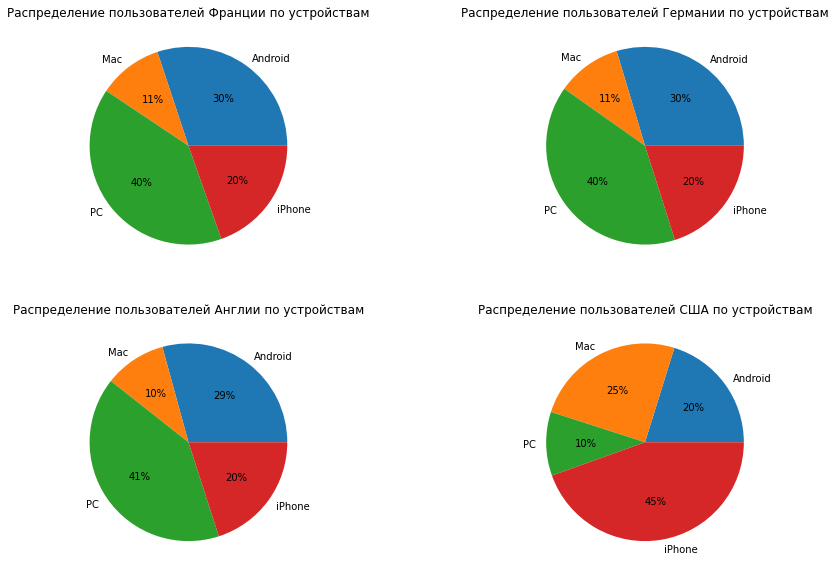

In [23]:
# посмотрим на круговые диаграммы по каждой стране
fig, ax = plt.subplots(2, 2, figsize = (15, 10),  squeeze=False)
ax[0][0].pie(region_device['France'], labels=region_device.device, autopct='%1.0f%%')
ax[0][0].set(title='Распределение пользователей Франции по устройствам')
ax[0][1].pie(region_device['Germany'], labels=region_device.device, autopct='%1.0f%%')
ax[0][1].set(title='Распределение пользователей Германии по устройствам')
ax[1][0].pie(region_device['UK'], labels=region_device.device, autopct='%1.0f%%')
ax[1][0].set(title='Распределение пользователей Англии по устройствам')
ax[1][1].pie(region_device['United States'], labels=region_device.device, autopct='%1.0f%%')
ax[1][1].set(title='Распределение пользователей США по устройствам')
plt.show()

По нашим графикам распределения видно, что в странах Европы предпочитают пользоваться приложением с PC - около 40%, в то время как в США самым популярным устройством является iPhone с показателем в 45%. Поэтому мы видим перекос и в общем графике по устройствам в пользу iPhone, так как пользователей из США в разы больше, чем из Европы.

#### Распределение пользователей по каналам привлечения.

In [24]:
#построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения
payer_of_channel = (
    profiles.groupby('channel')['user_id', 'payer']
    .agg({'user_id': 'nunique', 'payer':'sum'})
).reset_index()
payer_of_channel['payers_per'] = payer_of_channel['payer'] / payer_of_channel['user_id'] *100
payer_of_channel.sort_values(by='payers_per', ascending=False).style.format({'payers_per': '{:.2f}%'})

,channel,user_id,payer,payers_per
1,FaceBoom,29144,3557,12.20%
0,AdNonSense,3880,440,11.34%
9,lambdaMediaAds,2149,225,10.47%
6,TipTop,19561,1878,9.60%
5,RocketSuperAds,4448,352,7.91%
7,WahooNetBanner,8553,453,5.30%
8,YRabbit,4312,165,3.83%
3,MediaTornado,4364,156,3.57%
2,LeapBob,8553,262,3.06%
4,OppleCreativeMedia,8605,233,2.71%


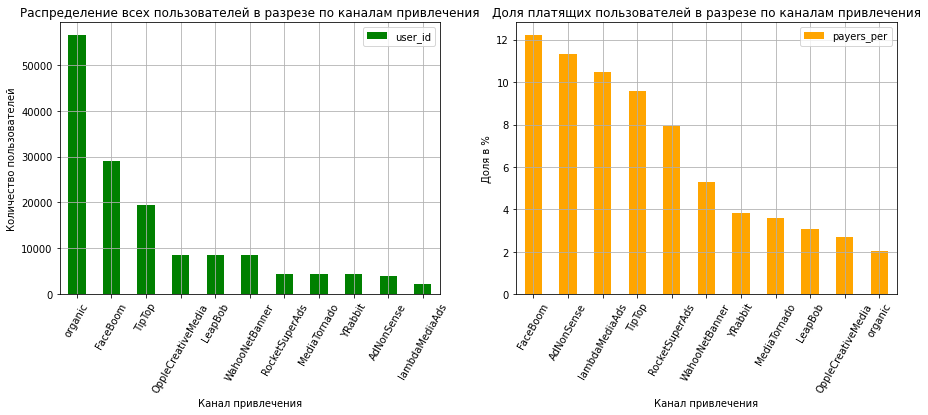

In [25]:
#построим графики для наглядности
plt.figure(figsize=(15, 5))

ax1 = plt.subplot(1, 2, 1)
payer_of_channel.sort_values(by='user_id', ascending=False).plot.bar(
                                                           x='channel', y='user_id', grid=True,
                                                           title='Распределение всех пользователей в разрезе по каналам привлечения', 
                                                           rot=60, color= 'green', ax=ax1).set(xlabel='Канал привлечения', 
                                                                               ylabel='Количество пользователей')

ax2 = plt.subplot(1, 2, 2)
payer_of_channel.sort_values(by='payers_per', ascending=False).plot.bar(
                                                             x='channel', y='payers_per', grid=True,
                                                             title='Доля платящих пользователей в разрезе по каналам привлечения',
                                                             rot=60,color='orange', ax=ax2).set(xlabel='Канал привлечения', 
                                                                                           ylabel='Доля в %')

plt.show()

In [26]:
#проверим, есть ли связь между каналом привлечения и страной
region_channel = (profiles
                   .query('payer == True')
                   .pivot_table(index='channel', 
                                columns = 'region', 
                                values = 'user_id', 
                                aggfunc='count')
                   .sort_values(by='United States', ascending = False)
)
region_channel

region,France,Germany,UK,United States
channel,,,,
FaceBoom,NaN,NaN,NaN,3557.0
TipTop,NaN,NaN,NaN,1878.0
organic,109.0,126.0,131.0,794.0
RocketSuperAds,NaN,NaN,NaN,352.0
YRabbit,NaN,NaN,NaN,165.0
MediaTornado,NaN,NaN,NaN,156.0
AdNonSense,150.0,142.0,148.0,NaN
LeapBob,90.0,69.0,103.0,NaN
OppleCreativeMedia,80.0,64.0,89.0,NaN


Мы видим, что у Америки и Европы разные каналы привлечения пользователей. Общим является только канал organic, но по этому каналу приходят клиенты, которые сами нашли приложение, то есть на них мы не тратим рекламный бюджет. 

Изучив рекламные источники привлечения, мы обнаружили, что всего каналов 11, один из них - organic, то есть эти пользователи находят приложение самостоятельно (этот канал является самым многочисленным, но доля переходящих в категорию платящих - всего 2%). Также мы выяснили, что каналы строго делятся на Европу и Америку.
Наибольшее количество платящих пользователей пришло из канала FaceBoom и TipTop. Что касается доли платящих пользователей, то лучше всего они конвертируются из следующих рекламных каналов: 
*FaceBoom*-12.20%, *AdNonSense*-11.34%, *lambdaMediaAds*-10.47%, *TipTop*-9.60%.

**Выводы**

- В наших данных представлена информация о пользователях с 1 мая 2019 по 27 октября 2019 года;
- Приложением пользуются в 4 странах: United States, UK, France и Germany. Подавляющее большинство пользователей (67%) из США, также среди них самая большая доля платящих клиентов (6,9%), оставшееся количество пользователей распределено практически равномерно между тремя странами Европы, доля платящих также особенно не отличается от страны к стране и составляет от 3.8% до 4.1%;
- Приложение используют на 4 видах устройств - Mac, PC, iPhone и Android. Самым популярным устройством, с которого пользователи заходят в приложение, является - iPhone, поэтому и платящих пользователей среди них больше. Однако, доля переходящих в категорию платящих чуть выше у Mac;
- Всего используется 10 рекламных источников, 5 из которых в США, 5 в Европе, также есть один общий источник с "органик" пользователями;
- Наибольшее количество платящих пользователей пришло из канала FaceBoom и TipTop;
- Лучше всего платящие пользователи конвертируются из следующих рекламных каналов: FaceBoom-12.20%, AdNonSense-11.34%, lambdaMediaAds-10.47%, TipTop-9.60%.

### Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника.

In [27]:
#посчитаем общую сумму расходов на маркетинг
total_costs = costs['costs'].sum()
print('Общая сумма расходов на маркетинг:', total_costs)

Общая сумма расходов на маркетинг: 105497.30000000002


In [28]:
#посмотрим распределние расходов по рекламным источникам
costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [29]:
#выделим столбцы с номером месяца и недели
costs['dt'] = pd.to_datetime(costs['dt'])
costs['month_costs'] = costs['dt'].dt.month
costs['week_costs'] = costs['dt'].dt.isocalendar().week

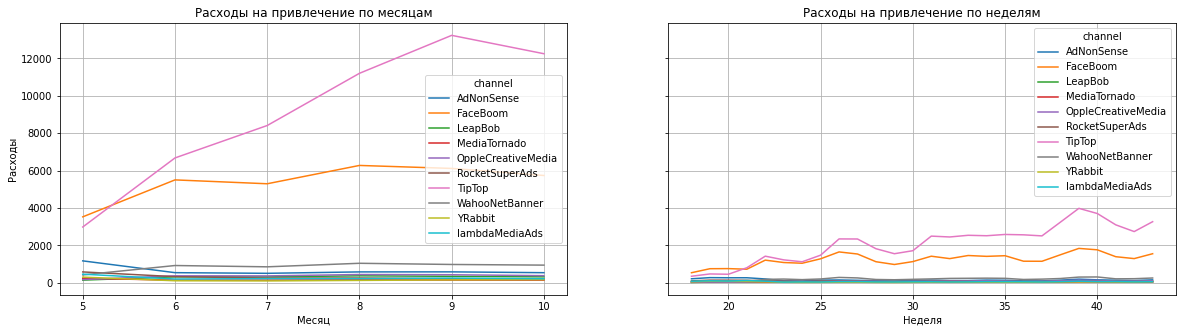

In [30]:
#построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику
month_costs = costs.pivot_table(index='month_costs', columns = 'channel', values = 'costs', aggfunc = 'sum')
ax1 = plt.subplot(1, 2, 1)
month_costs.plot(grid=True, ax=ax1, figsize=(20, 5))
plt.xlabel('Месяц')
plt.ylabel('Расходы')
plt.title('Расходы на привлечение по месяцам')

week_costs = costs.pivot_table(index='week_costs', columns = 'channel', values = 'costs', aggfunc = 'sum')
ax2 = plt.subplot(1, 2, 2, sharey=ax1)
week_costs.plot(grid=True, ax=ax2, figsize=(20, 5))
plt.xlabel('Неделя')
plt.ylabel('Расходы')
plt.title('Расходы на привлечение по неделям')

plt.show()

In [31]:
#посчитаем, сколько в среднем стоило привлечение одного пользователя из каждого источника
mean_cost_of_channel = profiles.groupby('channel')['acquisition_cost'].mean().sort_values(ascending=False)
mean_cost_of_channel

channel
TipTop                2.799003
FaceBoom              1.113286
AdNonSense            1.008054
lambdaMediaAds        0.724802
WahooNetBanner        0.602245
RocketSuperAds        0.412095
OppleCreativeMedia    0.250000
YRabbit               0.218975
MediaTornado          0.218717
LeapBob               0.210172
organic               0.000000
Name: acquisition_cost, dtype: float64

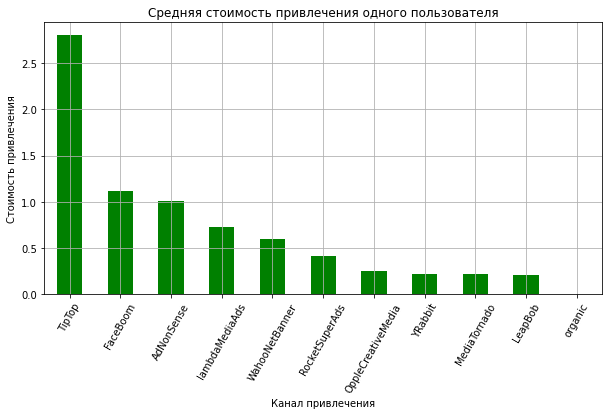

In [32]:
#визуализируем результат
mean_cost_of_channel.plot.bar(
                         grid=True, rot=60, color='green', figsize=(10, 5), title='Средняя стоимость привлечения одного пользователя').set(
                         xlabel="Канал привлечения", ylabel='Стоимость привлечения')
plt.show()

In [36]:
#посчитаем среднее значение по всем платным каналам
print('Средний CAC по платным каналам', profiles.query('channel != "organic"')['acquisition_cost'].mean().round(2))

Средний CAC по платным каналам 1.13


**Выводы**

- Общая сумма расходов на маркетинг составила 105497;
- Большая часть рекламного бюджета была израсходована на каналы TipTop и FaceBoom, 54751 и 32445 соответственно;
- Самым дорогим рекламным источником является TipTop, пик расходов приходится в этом канале на сентябрь 2019, в среднем привлечение одного пользователя через этот канал обходится в 2.799, что в 2.5 раза выше, чем среднее значение по всем платным каналам, второй по стоимости канал - FaceBoom - 1.1, на третьем месте по дороговизне канал - AdNonSense, где привлечение одного пользователя стоит в среднем 1;
- Самыми бюджетными рекламными источниками являются YRabbit, MediaTornado и LeapBob, через них привлечение одного пользователя обходится компании в 0.21.

### Оценим окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. На календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.

In [37]:
#уберем из анализа пользователей из категории organic, тк на них не тратится рекламный бюджет
profiles_new = profiles.query('channel != "organic"')

In [38]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

#### Общая окупаемость рекламы.

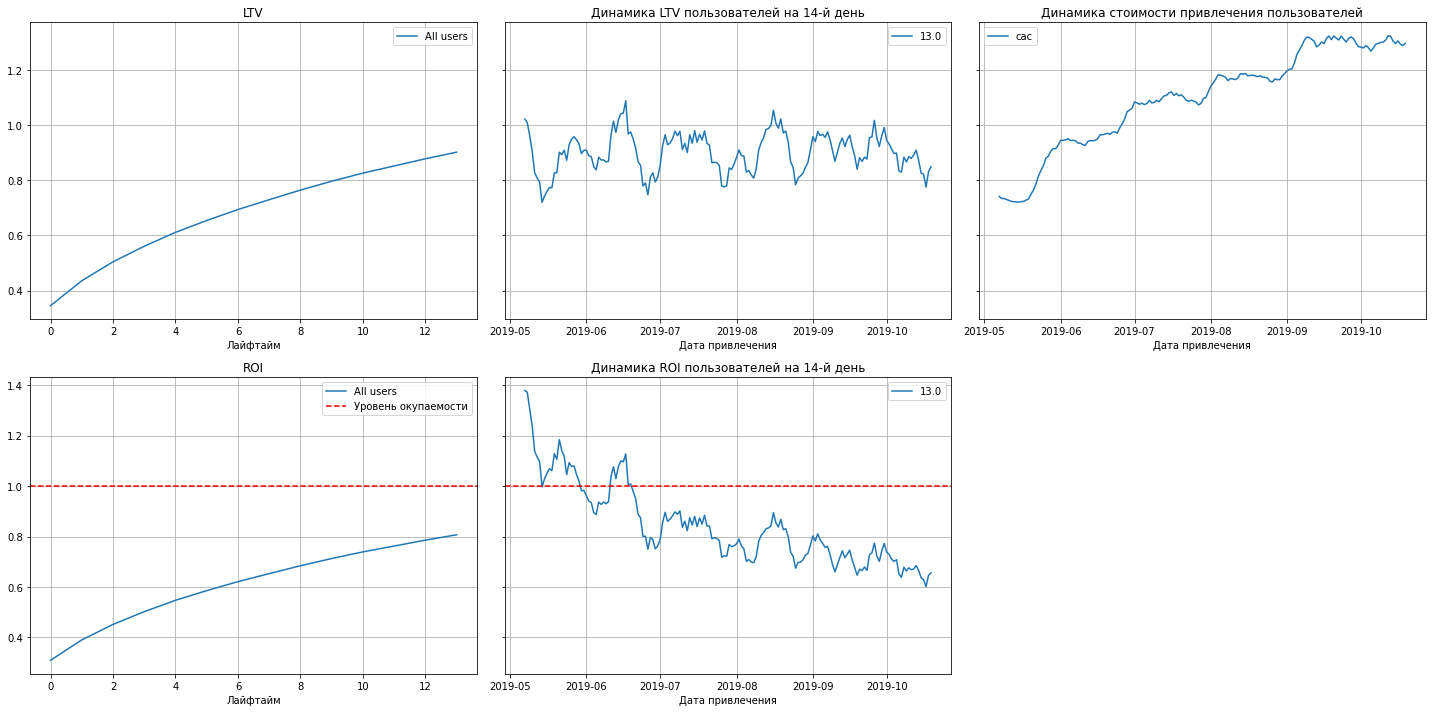

In [39]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new, orders, observation_date, horizon_days
)

# построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:

- Реклама не окупается. ROI в конце второй недели — 80%;
- Динамика стоимости привлечения пользователей - CAC, постоянно растет, что говорит об увеличении расходов на рекламу от месяца к месяцу;
- LTV достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

#### Построим и изучим графики конверсии и удержания.

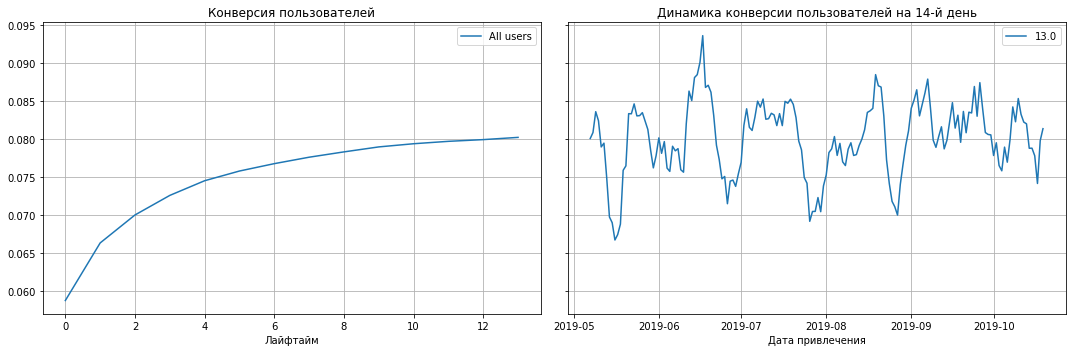

In [40]:
# смотрим конверсию 

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_new, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

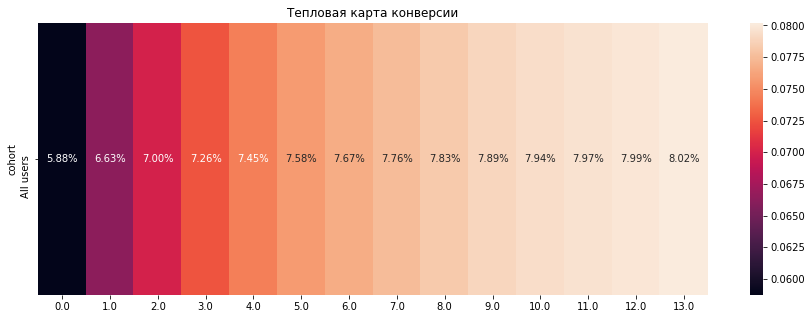

In [41]:
# строим хитмэп по таблице конверсии
plt.figure(figsize = (15, 5))
sns.heatmap(conversion_grouped.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии')
plt.show() 

По графику конверсии можем сделать вывод, что к 14 дню конвертируются в платящих пользователей 8.02% всех пользователей. Общая конверсия растёт: от 5,88% в первый день «жизни» пользователей до 8,02% на четырнадцатый день, также мы видим, что мы достигаем показателя 7% в первые три дня, далее идет плато.
Что касается динамики конверсии, тут мы видим, что она имеет скачкообразный вид, то есть за более успешным месяцем идет менее успешный и наоборот.

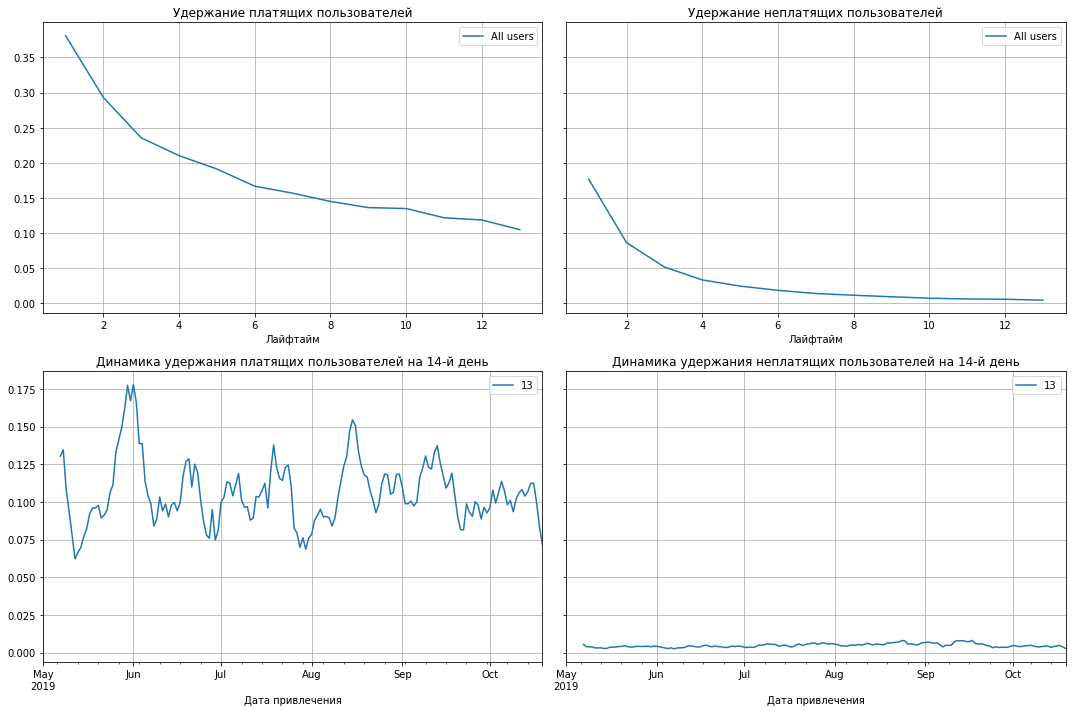

In [42]:
# смотрим удержание 
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_new, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

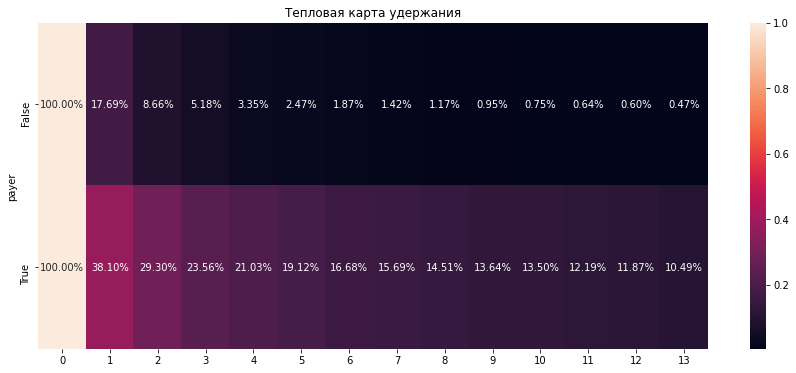

In [43]:
# строим хитмэп по таблице удержания
plt.figure(figsize = (15, 6))  # задаём размер графика
sns.heatmap(retention_grouped.drop(columns = ['cohort_size']),
            annot = True,  # включаем подписи
            fmt = '.2%'  # отображаем значения в виде процентов
           )
plt.title('Тепловая карта удержания')  # название графика
plt.show()

По удержанию пользователей и динамики его изменения можем сделать следущие выводы:

- Удержание платящих пользователей значительно выше удержания неплатящих. На второй день "жизни" в приложении остается 38.10% из числа платящих пользователей, против 17.69% среди неплатящих. К концу лайфтайма из числа платящих пользователей остается 10.49%, в то время как среди неплатящих уже к концу первой недели остается чуть меньше 2%, а в конце второй остется лишь 0.47%;
- Динамика удержания платящих пользователей имеет скачкообразный вид, меняется от месяца к месяцу, пик удержания приходится на конец мая-начало июня. Что касается неплатящих пользователей, тут иная картина, на протяжении всего времени в конце лайфтайма у нас околонулевые показатели, то есть удержание неплатящих клиентов у нас стабильно плохое всегда.

#### Окупаемость рекламы с разбивкой по устройствам.

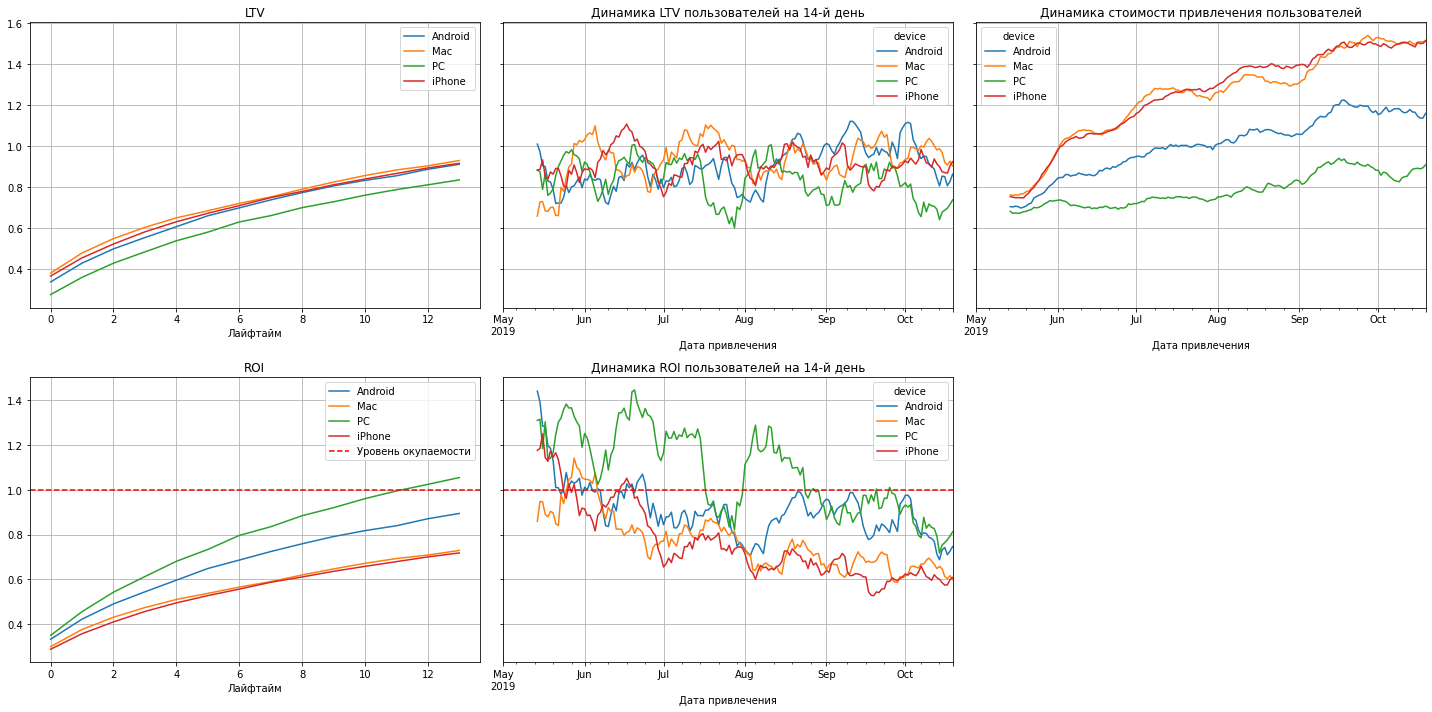

In [44]:
# смотрим окупаемость с разбивкой по устройствам, построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

По графикам окупаемости рекламы с разбивкой по устройствам можем сделать следующие выводы:

- LTV стабилен по всем устройствам, но PC все же показывает хуже результат, то есть пользователи PC для нас являются менее доходной категорией;
- Что касается динамики стоимости привлечения пользователей, то она растет на всех устройствах, но на Mac и iPhone она наиболее выражена, пик приходитя на сентябрь-октябрь;
- Реклама окупается только у пользователей PC и только к 12 дню "жизни", но с сентября реклама убыточна для всех устройств;
- Хуже всего показатели окупаемости по Mac и iPhone, несмотря на высокий LTV, так как затраты на нее слишком высоки.

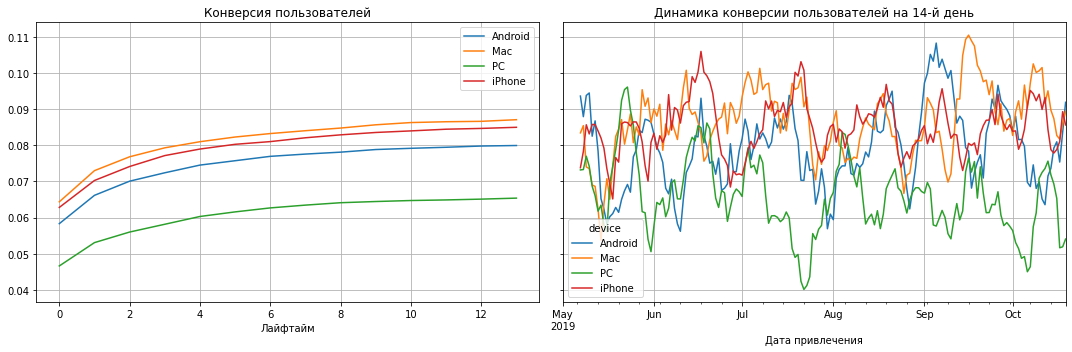

In [45]:
# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_new, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

График конверсии с рабивкой по устройствам нам показывает, что хуже всего показатель конверсии на PC, лучше всего конвертируются пользователи устройств Mac и iPhone, Android им немного уступает.

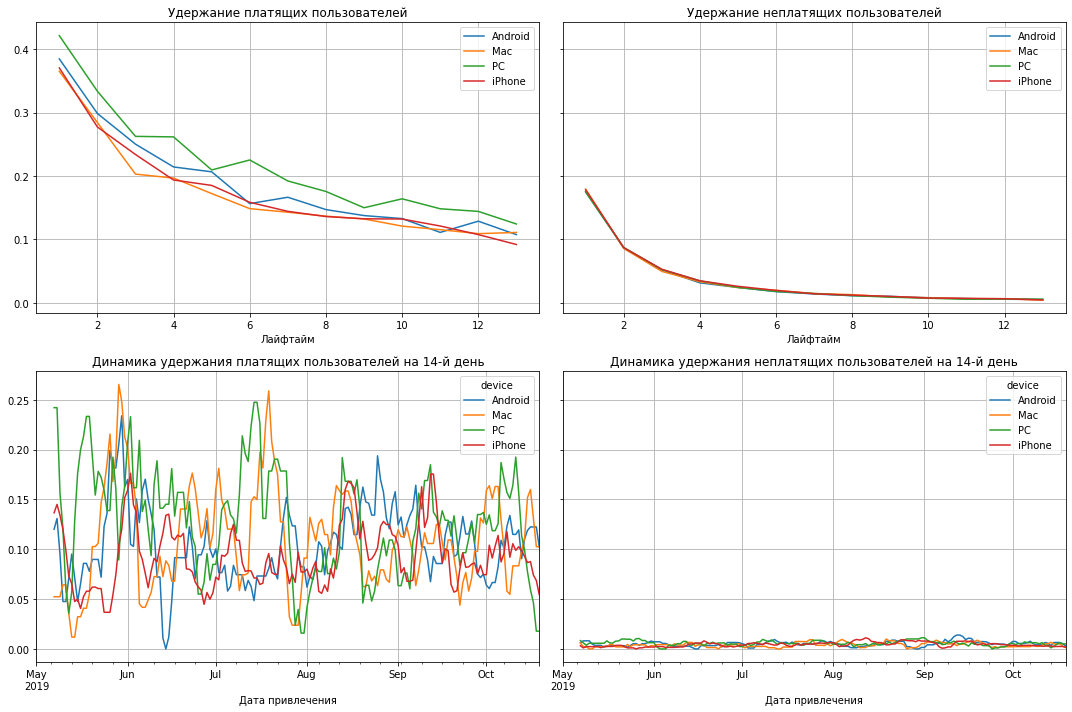

In [46]:
# смотрим удержание с разбивкой по устройствам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_new, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

Удержание неплатящих пользователей одинаково низко по всем устройствам, имеет околонулевые результаты.
По платящим пользователям все устройства стабильны, PC имеет показатель удержания чуть выше.

Проанализировав показатели окупаемости рекламы с разбивкой по устройствам, посмотрев конверсию и удержание, мы можем сделать вывод, что провал рекламной кампании и ее убыточность с устройствами не связаны, никаких аномальных значений, которые бы нам подсветили возможные технические или другие проблемы обнаружено не было. Поэтому мы дальше будем искать, куда слили рекламный бюджет.

#### Окупаемость рекламы с разбивкой по странам.

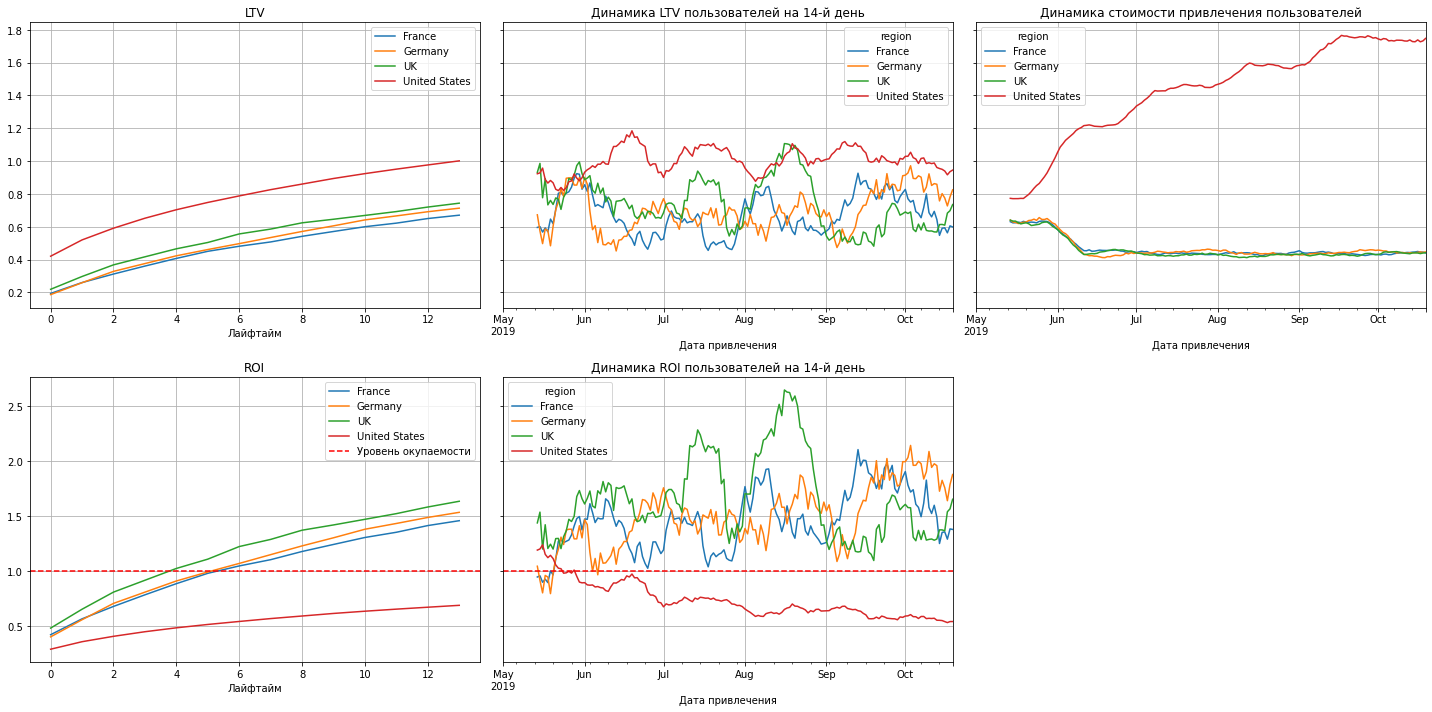

In [47]:
# построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Мы видим четкое разделение стран на две категории: Европа и США. Франция, Германия и Великобритания показывают примерно одинаковые результаты. 
- По показателям LTV Европа уступает США, то есть эти страны приносят меньше дохода; 
- Что касается стоимости привлечения пользователей, в странах Европы этот показатель стабилен и невысок, более того с середины июня он снижается и переходит на плато. В США наоборот, стоимость привлечения пользователей постоянно растет и в несколько раз выше, чем в Европе.
- В итоге реклама окупается во всех странах Европы, быстрее всего в Великобритании - уже к 5 дню, также мы видим, что наиболее успешные рекламные кампании проводились в Великобритании в июле и августе. Реклама в США не окупается совсем, на протяжении всего периода исследования.

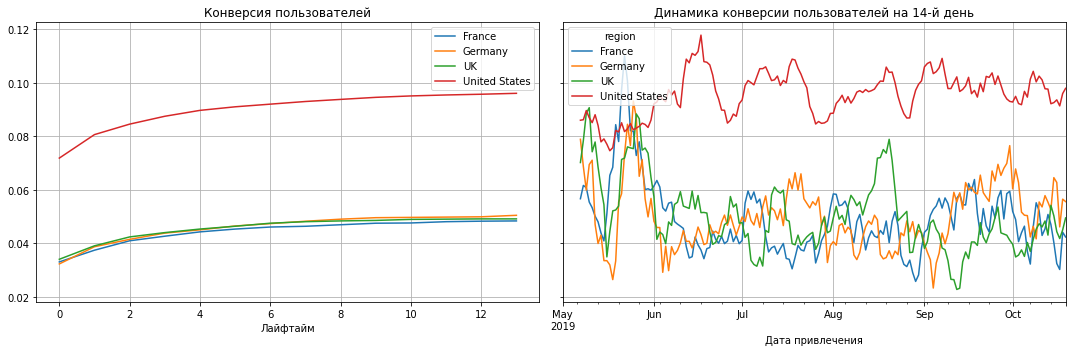

In [48]:
# также посмотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_new, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

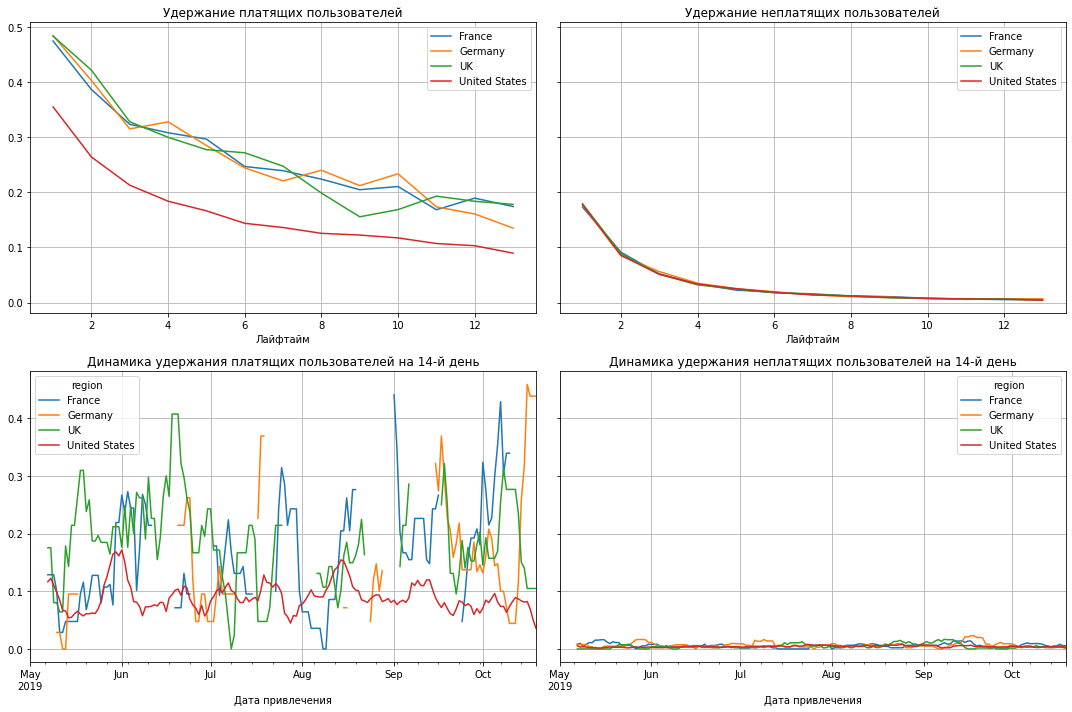

In [49]:
# смотрим удержание с разбивкой по странам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_new, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

График конверсии с разбивкой по странам нам показывает, что пользователи из США конвертируются стабильно намного лучше пользователей из стран Европы, при этом удержание платящих пользователей в США ниже, чем в европейских странах и именно в США реклама не окупается вовсе. Чтобы лучше разобраться в причинах, перейдем к самому интересному-разбору каналов привлечения, мы помним, что каналы различны для США и Европы, скорее всего дело в них.

#### Окупаемость рекламы с разбивкой по рекламным каналам.

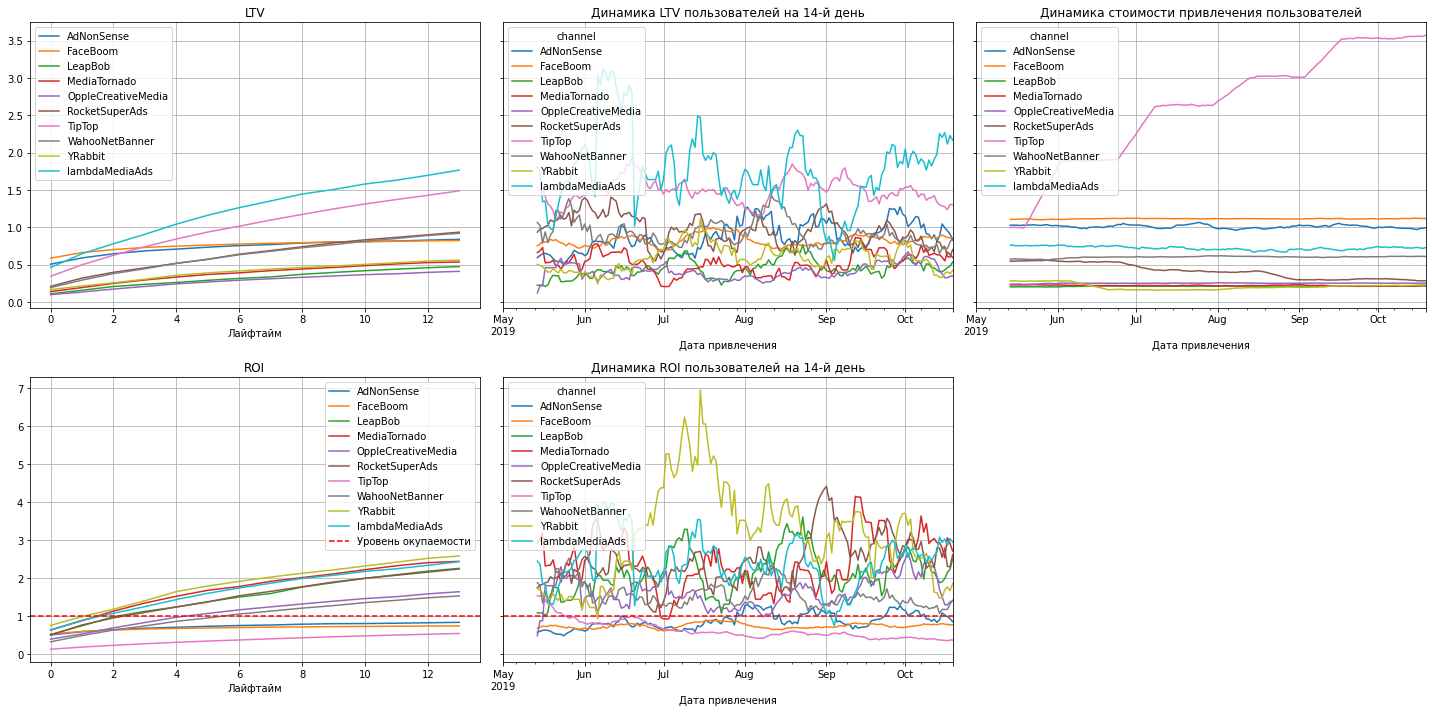

In [50]:
#построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI с разбивкой по источникам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_new, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Посмотрев окупаемость рекламы в разрезе по каналам привлечения, мы видим следующую картину:

- Самый высоки показатель LTV у каналов lambdaMediaAds и TipTop, то есть эти каналы приносят больше всего дохода;
- Что касается стоимости привлечения, тут сильно отличается динамика по каналу TipTop, здесь мы видим постоянное увеличение затрат на рекламу, которые в разы выше, чем по другим источникам, где стоимость стабильна одинакова. Поэтому при высоком LTV он имеет самый низкий ROI;
- Не достигают окупаемости за 14 дней такие каналы, как  TipTop, FaceBoom и AdNonSense, при этом TipTop и FaceBoom не показывали положительной динамики окупаемости за всю историю наблюдений, из-за высокой цены на рекламу эти каналы просто неэффективны;
- Быстрее всего уровня окупаемости достигают YRabbit, MediaTornado, lambdaMediaAds - уже на 2-3 день, также стабильно хороший уровень окупаемости мы видим у каналов RocketSuperAds и LeapBob. WahooNetBanner и OppleCreativeMedia окупаются только к концу первой недели;
- Также мы видим, что канал YRabbit окупается самым первым из-за низкой стоимости привлечения пользователей, при том, что уровень LTV не впечатляет и находится на достаточно низком уровне. Самым успешным месяцем для этого канала был июль, там мы видим всплекс, далее пошел спад;
- Одним из самых переспективных рекламных каналов мы можем назвать lambdaMediaAds, здесь мы видим стабильно самый высокий LTV, среднюю стоимость привлечения пользователей, и один из лучших показателей по окупаемости рекламы. Как мы помним, данный рекламный канал актуален для европейских стран;
- В США наиболее преспективным является канал RocketSuperAds, тут мы видим стабильный LTV, стоимость привлечения пользователей ниже среднего и реклама окупается уже на 3 день.

Для того чтобы удостовериться в правильности выбора, также построим графики конверсии и удержания с разбивкой по рекламным источникам.

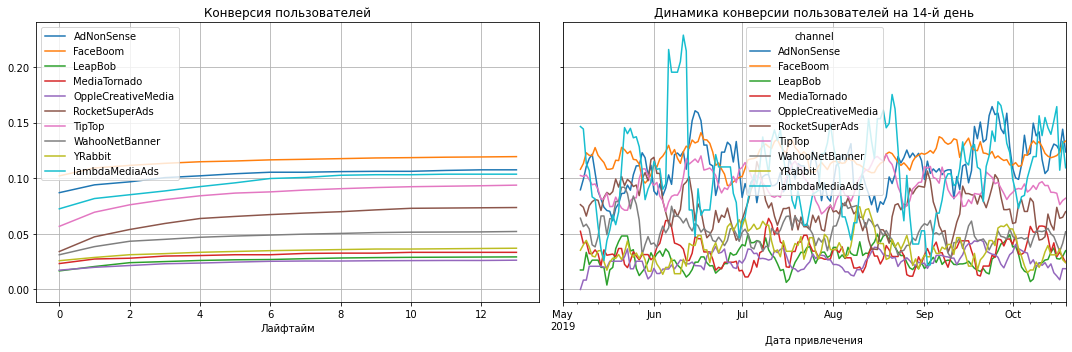

In [51]:
# смотрим конверсию с разбивкой по рекламным каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_new, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

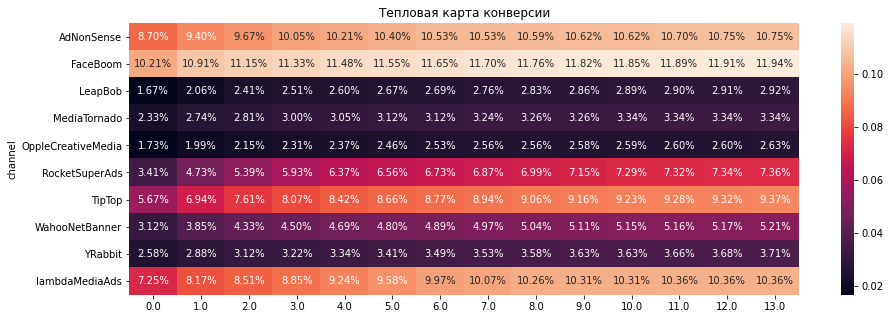

In [52]:
# строим хитмэп по таблице конверсии
plt.figure(figsize = (15, 5))
sns.heatmap(conversion_grouped.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта конверсии')
plt.show()

Мы построили график конверсии и тепловую карту, полагаясь на эти данные можем обозначить топ-5 рекламных каналов, где пользователи лучше всего конвертируются в платящих:

- FaceBoom - 11.94%
- AdNonSense - 10.75%
- lambdaMediaAds - 10.36%
- TipTop - 9.37%
- RocketSuperAds - 7.36%

Хуже всего результаты у OppleCreativeMedia и LeapBob - менее 3%.

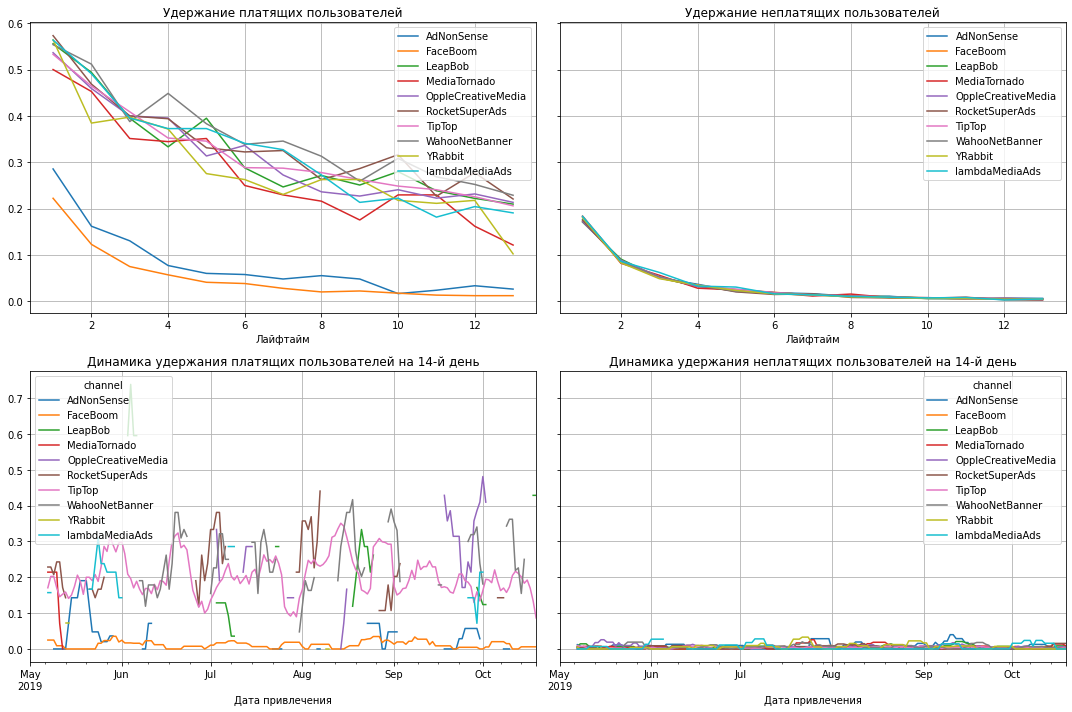

In [53]:
# смотрим удержание с разбивкой по рекламным каналам

retention_raw, retention_grouped, retention_history = get_retention(
    profiles_new, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days) 

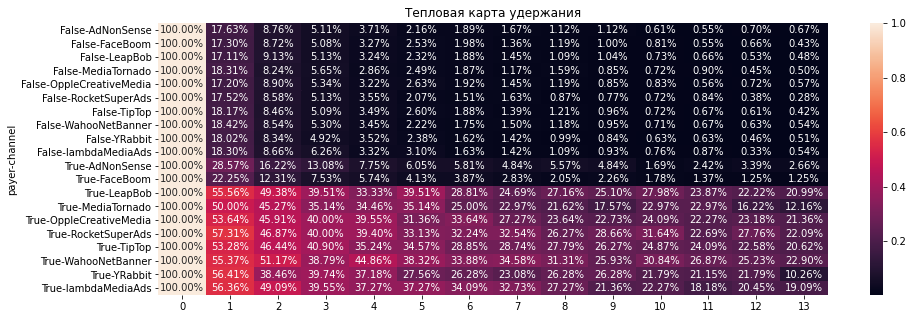

In [54]:
# строим хитмэп по таблице удержания
plt.figure(figsize = (15, 5))
sns.heatmap(retention_grouped.drop(columns=['cohort_size']), annot=True, fmt='.2%')
plt.title('Тепловая карта удержания')
plt.show()

По данным об удержании пользователей можем сделать следующие выводы:

 - Неплатящие пользователи удерживаются одинаково плохо по всем источникам привлечения;
 - У каналов FaceBoom и AdNonSense худшие результаты удержания платящих пользователей, скорее всего оттуда приходит нецелевая аудитория;
 - В остальных каналах по платящим пользователям мы видим стабильно высокий уровень удержания.

**Выводы**

- Реклама, направленная на привечение пользователей в целом, не окупается, в конце второй недели уровень достигает лишь 80%. Динамика стоимости привлечения пользователей постоянно растет, что говорит об увеличении расходов на рекламу от месяца к месяцу;
- Что касается окупаемости рекламы с разбивкой по устройствам, мы видим, что реклама окупается только для PC и только в конце лайфтайма. Более доходной категорией являются пользователи Mac и iPhone (Android отстает совсем немного), также они имеют выше конверсию, но из-за высокой стоимости привлечения новых пользователей, реклама не окупается. Но несмотря на то, что разница по разным показателям среди устройств есть, мы пришли к выводу, что она не столь существенна и причины провала рекламной кампании кроются в другом, никаких аномальных значений, которые бы нам подсветили возможные технические или другие проблемы с определнными устройствами обнаружено не было;
- Перейдем к анализу окупаемости по странам. Мы видим четкое разделение стран на две категории: Европа(Германия,Франция и Великобритания, где все показатели примерно одинаковые) и США. Показатель LTV выше у США, чем у стран Европы, то есть Америка приносит больше дохода. При этом стоимость привлечения пользователей в разы выше, чем в Европе. Конверсия в США также значительно выше, чем в европейских странах, а вот удержание платящих пользователей в США ниже. Из-за высокой стоимости привлечения пользователей и низкого уровня их удержания рекламная кампания в США терпит убытки, в то время как в Европе реклама окупается во всех странах.
- Выводы по каналам привлечения мы сделаем максимально подробные, показав плюсы и минусы каждого источника:

- *TipTop* (США) -  высокий LTV, то есть этот канал показывает стабильно хороший доход, также высокий уровень конверсии и удержания, к нам приходят качественные пользователи. Но стоимость привлечения одного пользователя в разы выше, чем у других источников, поэтому канал показывает самый низкий уровень окупаемости и именно туда ушла половина всего рекламного бюджета;
- *FaceBoom* (США) - средний LTV, лучший уровень конверсии, стоимость привлечения пользователей выше среднего, худший показатель удержания, по какой-то причине не можем заинтерсовать данную аудиторию, в итоге реклама не окупается и туда ушла почти треть от всего бюджета;	
- *WahooNetBanner* (Европа) - средний LTV, средняя стоимость привлечения пользователей, конверсия ниже среднего, один из лучших показателей удержания. Привлеченные пользователи неохотно переходят в статус платящих, но остаются надолго, реклама окупается;
- *AdNonSense* (Европа) - средний LTV, высокий уровень конверсии, стоимость привлечения выше среднего, один из худших показателей удержания пользователей. Пользователи охотно приходят, но быстро уходят, реклама не окупается;	
- *OppleCreativeMedia* (Европа) - самый низкий LTV, худший показатель конверсии, стоимость привлечения пользователей невысокая, хороший показатель удержания. Реклама окупается, но большого внимания канал не стоит;
- *RocketSuperAds* (США) - стабильный LTV, средний уровень конверсии, стоимость привлечения ниже среднего, один из лучших показателей удержания. Реклама быстро окупается, на этот канал стоит обратить внимание;
- *LeapBob*	(Европа) - невысокий LTV, один из самых низких уровней конверсии, низкая стоимость привлечения пользователей, хороший уровень удержания, реклама окупается;
- *lambdaMediaAds* (Европа) - стабильно высокий LTV, отличная конверсия, средняя стоимость привлечения, хорошее удержание пользователей. Реклама окупается быстро, рекомендация обратить внимание на данный источник;
- *MediaTornado* (США)-	низкий LTV, низкая конверсия, один из самых бюджетных каналов привлечения, среднее удержание. реклама окупается;
- *YRabbit* (США) - невысокий LTV, низкая конверсия, самый дешевый канал привлечения, среднее удержание. Самая быстрая окупаемость рекламы;

Мы видим, что рекламный бюджет ушел не в самые эффективные источники привлечения, половина бюджета была потрачена на канал TipTop, где очень высокая стоимость привлечения клиентов, несмотря на их качество, также распределение бюджета на каналы FaceBoom и AdNonSense с низким удержанием пользователей привели к тому, что рекламная кампания не окупилась.

### Общие выводы.

В наших данных представлена информация о пользователях приложения Procrastinate Pro+ с 1 мая 2019 по 27 октября 2019 года.
Мы выяснили, что приложением пользуются в 4 странах: United States, UK, France и Germany. Подавляющее большинство пользователей (67%) из США, также среди них самая большая доля платящих клиентов (6,9%), оставшееся количество пользователей распределено практически равномерно между тремя странами Европы, доля платящих также особенно не отличается от страны к стране и составляет от 3.8% до 4.1%.

Приложение используют на 4 видах устройств - Mac, PC, iPhone и Android. Самым популярным устройством, с которого пользователи заходят в приложение, является - iPhone, так как это самое популярное устройство среди пользователей из США, которые составяют большинство.

Всего для привлечения новых пользователей представлено 10 рекламных источников, 5 из которых в США, 5 в Европе, также есть один общий источник с "органик" пользователями, которые находят приложение сами и их у нас чуть больше половины от всех пользователей.

Общая сумма расходов на маркетинг составила 105497. Большая часть рекламного бюджета была израсходована на каналы TipTop и FaceBoom, 54751 и 32445 соответственно. Самым дорогим рекламным источником является TipTop, пик расходов приходится в этом канале на сентябрь 2019, в среднем привлечение одного пользователя через этот канал обходится в 2.799, что в 2.5 раза выше, чем среднее значение по всем платным каналам, второй по стоимости канал - FaceBoom - 1.1, на третьем месте по дороговизне канал - AdNonSense, где привлечение одного пользователя стоит в среднем 1.
Самыми бюджетными рекламными источниками являются YRabbit, MediaTornado и LeapBob, через них привлечение одного пользователя обходится компании в 0.21.

Реклама, направленная на привечение пользователей в целом, не окупается, в конце второй недели уровень достигает лишь 80%. Динамика стоимости привлечения пользователей постоянно растет, что говорит об увеличении расходов на рекламу от месяца к месяцу.

В разрезе по странам мы видим, что реклама окупается в странах Европы, но не окупается в США, несмотря на  то, что конверсия пользователей США в 2 раза выше , чем в европейских странах, при этом коэффициент удержания у платящих пользователей из США значительно ниже. То есть при высокой конверсии покупатели США быстро уходят из приложения. При детальном рассмотрении рекламных каналов видно, что убыточны два самых крупных канала привлечения в США - TipTop и FaceBoom и один канал Европы - AdNonSense.

- TipTop (США) - высокий LTV, то есть этот канал показывает стабильно хороший доход, также высокий уровень конверсии и удержания, к нам приходят качественные пользователи. Но стоимость привлечения одного пользователя в разы выше, чем у других источников и CAC постоянно растет, поэтому канал показывает самый низкий уровень окупаемости и именно туда ушла половина всего рекламного бюджета;
- FaceBoom (США) - также стабильно убыточен, средний LTV, лучший уровень конверсии, стоимость привлечения пользователей выше среднего, худший показатель удержания, по какой-то причине не можем заинтерсовать данную аудиторию, в итоге реклама не окупается и туда ушла почти треть от всего бюджета;
- AdNonSense (Европа) - средний LTV, высокий уровень конверсии, стоимость привлечения выше среднего, один из худших показателей удержания пользователей. Пользователи охотно приходят, но быстро уходят, реклама не окупается. Но в целом он не смог повлиять критично на рынок Европы, так как остальные каналы привлечения окупаются.

С учетом того, что рынок США составляет 67% от общей массы пользователей, убытки от привлечения пользователей страны полностью перекрывают доходы окупаемых стран. 
Итоговой причиной убытков компании за представленный период - маркетинг, направленный в большей мере на привлечение пользователей по двум источникам: TipTop и FaceBoom. Расходы, потраченные на рекламу в этих каналах значительно превышают выручку, которую приносят пришедшие в приложение пользователи. У FaceBoom при высоком уровне конверсии плохое качество привлекаемых пользователей, они не задерживаются в нашем приложении надолго, а у TipTop слишком высокие расходы на привлечение и это влияет отрицательно на финансовый результат компании. 

**Рекомендации отделу маркетинга**

- Постараться проанализировать в чем причина плохого удержания пользователей каналов FaceBoom и AdNonSense, почему приложение не оправдывает их ожидания? Попробовать изучить эту группу пользователей с помощью обратной связи и после чего решить, целесообразно ли продолжать привлечение через данные каналы.
- Оценить целесооразность высокой стоимости привлечения в канале TipTop, ведь оттуда мы получаем действительно качественных клиентов. Попробовать добиться уменьшения затрат на данный канал путем переговоров с данным источником привлечения, в случае отказа в снижении стоимости - перераспределить рекламный бюджет на другие каналы.
- Наиболее перспективными и эффективными рекламными каналами мы можем назвать lambdaMediaAds в Европе и RocketSuperAds в США, там мы видим хороший уровень окупаемости и конверсии пользователей при высоком уровне их удержания и средней стоимости привлечения, на них стоит обратить внимание впервую очередь.